In [3]:
import os
import sys

# Get the absolute path to the src directory from root
src_path = os.path.abspath(os.path.join(os.getcwd(), "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)


from utils import *
from optimize import *
from format_features import *
from train_n_eval import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

from scipy import stats
from scipy.optimize import minimize
from scipy.stats import pearsonr
from scipy.stats import ks_2samp

import xgboost as xgb

sns.set_style('ticks')

### 1. Read in sparse and dense features

In this section we prepare to formatt train-test data:

1. Each mixture feature will be defined as a combination (combining function depends on feature being sparse or dense) of the odor molecules;
2. For the random forest model trained on dense or sparse features, the features of an input pair will be defined as the concatinated features of mixture 1 and mixture 2, along with huristic engineered features; 
3. For the training set, we augment each sample into two symmetric inputs with the same prediction, by swapping mixture 1 and mixture 2's feature position.


In [4]:
input_path = './Data/'

# Seleted Mordred Descriptors
features_file_1 = 'Features/selection_cleanMordredDescriptors.csv'
# FullD Deepnose updated features 
features_file_2 =  'Features/deepnose_features.npy'

# Morgan fingerprint 50 dimension
features_file_3a = 'Features/Morgan_Fingerprints_Frequency_Size50.csv'
# AtomPair fingerprint 50 dimension
features_file_3c = 'Features/AtomPairs_Fingerprints_Frequency_Size50.csv'
# Full leffingwell updated features; absent molecules filled with deepnose predictions
features_file_4 =  'Features/leffingwell_features.npy'

# Mapping helper files
CID_file = 'molecules_train_cid.npy'
mixture_file = 'Mixure_Definitions_Training_set.csv'

# Feature CID in order 
features_CIDs = np.load(os.path.join(input_path, CID_file))
# Mixture definitions
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))

# Dense features
features_1 = pd.read_csv(os.path.join(input_path, features_file_1), index_col= 0)
features_2 = np.load(os.path.join(input_path, features_file_2))

# Sparse features
features_3a = pd.read_csv(os.path.join(input_path, features_file_3a), index_col= 0)
features_3c = pd.read_csv(os.path.join(input_path, features_file_3c), index_col= 0)
features_4 = np.load(os.path.join(input_path, features_file_4))

In [5]:
# Transform dense features:
scaler = StandardScaler(with_mean=True, with_std=True)

# Standardize Mordred
features_1_np = scaler.fit_transform(features_1)
features_1 = pd.DataFrame(features_1_np, columns=features_1.columns, index=features_1.index)

# Log standardize Deepnose
scaler = StandardScaler(with_mean=True, with_std=True)
epsilon = 1e-8 
features_2 = scaler.fit_transform(np.log(features_2 + epsilon))

In [6]:
# Map CID to features:

# Dense
CID2features_deepnose=  {CID: features_2[i] for i, CID in enumerate(features_CIDs)}
CID2features_mordred = {CID: np.array(features_1.loc[CID].tolist()) if CID in features_1.index else np.full(len(features_1.columns), np.nan) for CID in features_CIDs}

# Sparse
CID2features_morgan =  {CID: features_3a.loc[CID].tolist() for CID in features_CIDs}
CID2features_atomic =  {CID: features_3c.loc[CID].tolist() for CID in features_CIDs}
CID2features_leffingwell = {CID: features_4[i] for i, CID in enumerate(features_CIDs)}

In [7]:
features_list_dense = [CID2features_mordred, CID2features_deepnose]
features_list_sparse = [CID2features_morgan, CID2features_atomic, CID2features_leffingwell]

In [8]:
# Training set for leaderboard
X_dense_train_copies, X_dense_train, y_true_train = stacking_symmetric_X_features(features_list_dense, "avg", "training")
X_sparse_train_copies, X_sparse_train, _ = stacking_symmetric_X_features(features_list_sparse, "sum", "training") 

# Training set + leaderboard set, for test
X_dense_all_copies, X_dense_all, y_true_all = stacking_symmetric_X_features(features_list_dense, "avg", "all")
X_sparse_all_copies, X_sparse_all, _ = stacking_symmetric_X_features(features_list_sparse, "sum", "all")

# Leaderboard set
X_dense_leaderboard, y_true_leaderboard = stacking_X_test_features(features_list_dense,   X_dense_train_copies[0], X_dense_train_copies[1], "avg", "leaderboard")
X_sparse_leaderboard, _ = stacking_X_test_features(features_list_sparse,  X_sparse_train_copies[0], X_sparse_train_copies[1], "sum",  "leaderboard")

# Test set
X_dense_test, _ = stacking_X_test_features(features_list_dense,  X_dense_all_copies[0],  X_dense_all_copies[1], "avg", "test")
X_sparse_test, _ = stacking_X_test_features(features_list_sparse,  X_sparse_all_copies[0],  X_sparse_all_copies[1], "sum",  "test")

In [9]:
print(f'Finished formatting for {X_dense_train.shape[0]} training samples of {X_dense_train.shape[1]} feature dimension for the dense feature model;')
print(f'Finished formatting for {X_sparse_train.shape[0]} training samples of {X_sparse_train.shape[1]} feature dimension for the sparse feature model.')

Finished formatting for 1000 training samples of 346 feature dimension for the dense feature model;
Finished formatting for 1000 training samples of 413 feature dimension for the sparse feature model.


----

### 2. Training with dense feature model, sparse feature model, and different meta models over the dense and sparse predictions combined

Below we show the 10-fold cross validation result within the training set, for the hyperparameter optimized random forest models over the dense features, the sparse features, and different meta models. 

We evaluate the RMSE and Correlation by either averaging over the augmented pair, of the individual samples.

In [10]:
n_folds = 10
seed = 314159

# Obtained from hyper parameter optimization (script not included, code is in src.optimize)

best_rf_dense = {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
best_rf_sparse = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30, 'bootstrap': True}


In [11]:
# Define base models
base_model_dense = RandomForestRegressor(**best_rf_dense, random_state=seed)
base_model_sparse = RandomForestRegressor(**best_rf_sparse, random_state=seed)

In [12]:
meta_models = {
    'Ridge': Ridge(),
    'Poly_Ridge': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'RF': RandomForestRegressor(random_state=seed),
    'GB': GradientBoostingRegressor(random_state=seed),
    'KNN': KNeighborsRegressor()
}

In [13]:
results = stacking_ensemble_cv_averaged(X_dense_train, X_sparse_train, y_true_train, base_model_dense, base_model_sparse, meta_models, n_folds=10, seed=314159)

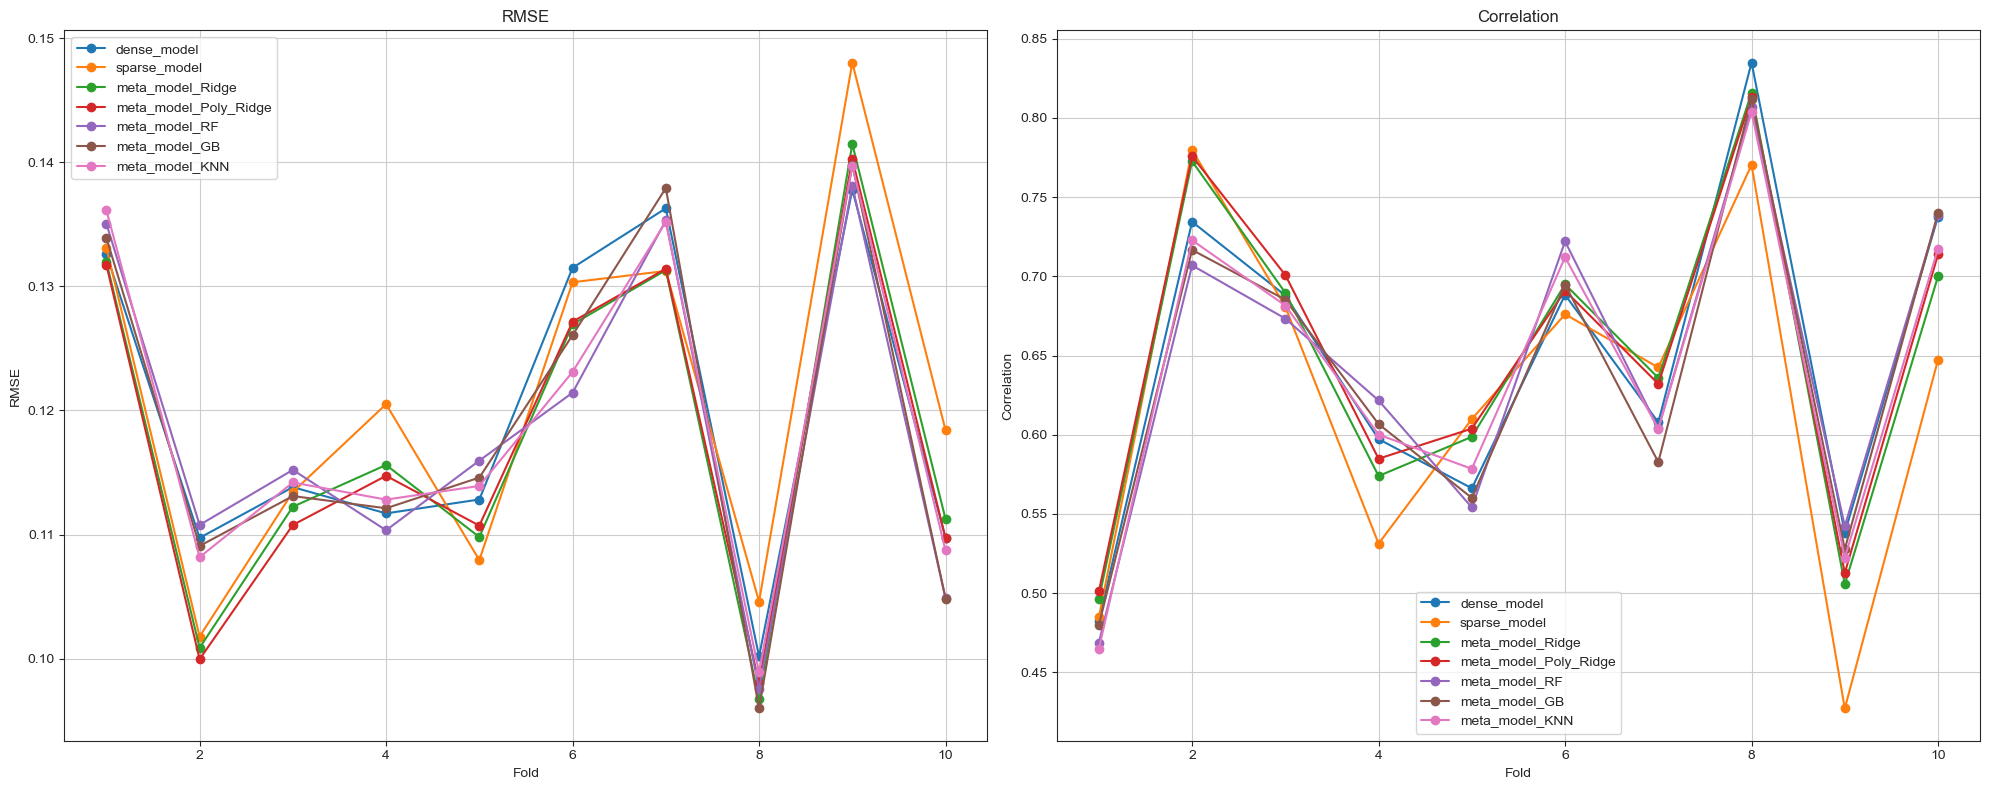

In [14]:
visualize_fold_results_averaged(results['fold_results'])

There are quite a lot of variablity between folds, but overall the meta models are more stable and had better overall performance and fold-wise performance compared to the two base models:

In [15]:
print_results(results)

Overall Performance:

dense_model:
  RMSE: 0.1203
  Correlation: 0.6511

sparse_model:
  RMSE: 0.1217
  Correlation: 0.6286

meta_model_Ridge:
  RMSE: 0.1186
  Correlation: 0.6525

meta_model_Poly_Ridge:
  RMSE: 0.1182
  Correlation: 0.6563

meta_model_RF:
  RMSE: 0.1192
  Correlation: 0.6507

meta_model_GB:
  RMSE: 0.1196
  Correlation: 0.6470

meta_model_KNN:
  RMSE: 0.1198
  Correlation: 0.6462


Fold Results Summary:

dense_model:
  RMSE:
    Mean ± Std: 0.1196 ± 0.0128
    Min: 0.1002
    Max: 0.1378
  Correlation:
    Mean ± Std: 0.6476 ± 0.1020
    Min: 0.4826
    Max: 0.8350

sparse_model:
  RMSE:
    Mean ± Std: 0.1209 ± 0.0139
    Min: 0.1018
    Max: 0.1480
  Correlation:
    Mean ± Std: 0.6250 ± 0.1093
    Min: 0.4272
    Max: 0.7798

meta_model_Ridge:
  RMSE:
    Mean ± Std: 0.1178 ± 0.0138
    Min: 0.0967
    Max: 0.1415
  Correlation:
    Mean ± Std: 0.6484 ± 0.1009
    Min: 0.4963
    Max: 0.8160

meta_model_Poly_Ridge:
  RMSE:
    Mean ± Std: 0.1174 ± 0.0136
    Min: 0

---

### 3. Train final models

Here we train two groups of final models, without and with augmentation with leaderboard data. 


In [16]:
# Define meta-models, a bit different from cv, as here random state and other argument are specified within the loop
meta_models = {
    'Ridge': Ridge,
    'Poly_Ridge': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'RF': RandomForestRegressor,
    'GB': GradientBoostingRegressor,
    'KNN': KNeighborsRegressor
}

In [17]:
# Train final models
final_models = train_final_models(X_dense_train, X_sparse_train, y_true_train, RandomForestRegressor, RandomForestRegressor, meta_models)
final_models_aug = train_final_models(X_dense_all, X_sparse_all, y_true_all, RandomForestRegressor, RandomForestRegressor, meta_models)

#### 3.1. Eval on training data itself:

In [18]:
# Evaluate on training data
train_predictions = predict_stacked_ensemble(X_dense_train, X_sparse_train, final_models)
train_predictions_aug =  predict_stacked_ensemble(X_dense_all, X_sparse_all, final_models_aug)

In [19]:
print("Training on Training Set Performance:")
print()
for name, preds in train_predictions.items():
    rmse, corr = evaluate_performance(y_true_train, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")
print()

print("Training on Training + Leaderbarod Performance:")
print()
for name, preds in train_predictions_aug.items():
    rmse, corr = evaluate_performance(y_true_all, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

Training on Training Set Performance:

Ridge - RMSE: 0.0319, Correlation: 0.9808
Poly_Ridge - RMSE: 0.0315, Correlation: 0.9797
RF - RMSE: 0.0111, Correlation: 0.9976
GB - RMSE: 0.0195, Correlation: 0.9922
KNN - RMSE: 0.0242, Correlation: 0.9883

Training on Training + Leaderbarod Performance:

Ridge - RMSE: 0.0321, Correlation: 0.9804
Poly_Ridge - RMSE: 0.0313, Correlation: 0.9801
RF - RMSE: 0.0106, Correlation: 0.9978
GB - RMSE: 0.0197, Correlation: 0.9921
KNN - RMSE: 0.0235, Correlation: 0.9890


#### 3.2. Eval on leaderboard (for final model not trained on leaderboard):

We have collected leaderboard expected prediction and here is an in-house evaluation: 

In [20]:
print("\nLeaderbaord Performance (base models):")
print()

base_predictions, base_predictions_mean = predict_base_models(X_dense_leaderboard, X_sparse_leaderboard, final_models)

for name, preds in base_predictions_mean.items():
    rmse, corr = evaluate_performance(y_true_leaderboard, preds) 
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")


Leaderbaord Performance (base models):

dense - RMSE: 0.1180, Correlation: 0.7106
sparse - RMSE: 0.1266, Correlation: 0.6310


In [21]:
print("\nLeaderbaord Performance (meta models):")
print()
# Evaluate on test data
leaderboard_predictions = predict_stacked_ensemble(X_dense_leaderboard, X_sparse_leaderboard, final_models)

for name, preds in leaderboard_predictions.items():
    rmse, corr = evaluate_performance(y_true_leaderboard, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")


Leaderbaord Performance (meta models):

Ridge - RMSE: 0.1195, Correlation: 0.6812
Poly_Ridge - RMSE: 0.1211, Correlation: 0.6745
RF - RMSE: 0.1139, Correlation: 0.7165
GB - RMSE: 0.1144, Correlation: 0.7132
KNN - RMSE: 0.1170, Correlation: 0.6969


From the above diagnosis from leaderboard performance, RF meta model performs the best out of all other meta model types, and it is less prone to overfit than Gradient Boost model. Therefore, we decided to use the RF model as the final model.

#### 3.3. Visualizing Performance on leaderboard:

We can also visualize how well we peroform on leaderboard data:

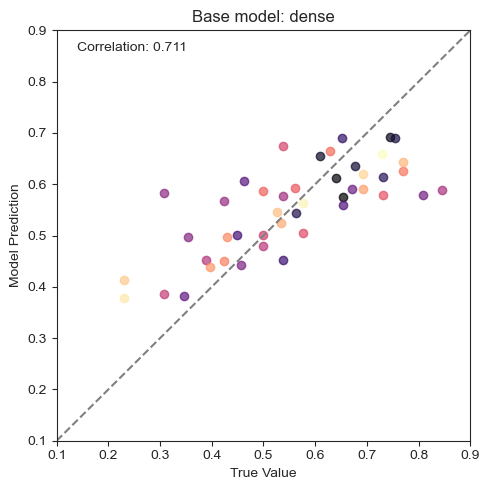

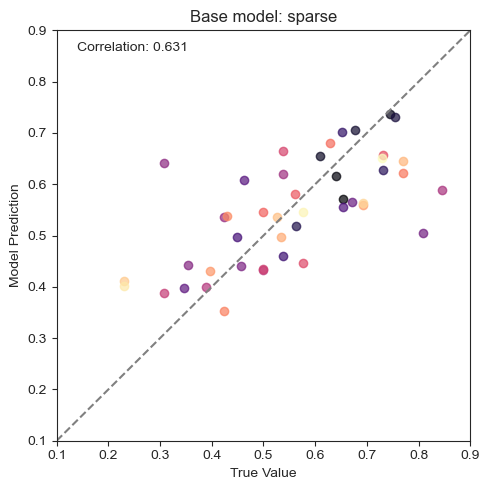

In [22]:
# Color map for all data points
num_points = len(base_predictions_mean[list(base_predictions_mean.keys())[0]])
colors = plt.cm.magma(np.linspace(0, 1, num_points))

for base_model in base_predictions_mean.keys():
    plt.figure(figsize=(5, 5))
    
    # Use the same color for each point across all plots
    for i in range(num_points):
        y_true = (y_true_leaderboard[0::2] +  y_true_leaderboard[1::2])/2
        plt.scatter(y_true[i], 
                    base_predictions_mean[base_model][i], 
                    color=colors[i], 
                    alpha=0.7)

    plt.xlim(.1, .9)
    plt.ylim(.1, .9)
    plt.xlabel('True Value')
    plt.ylabel('Model Prediction')
    plt.title(f'Base model: {base_model}')
    
    # Add y=x line
    plt.plot([.1, .9], [.1, .9], color='grey', linestyle='--')

    # Calculate and add correlation
    correlation, _ = stats.pearsonr(y_true, base_predictions_mean[base_model])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

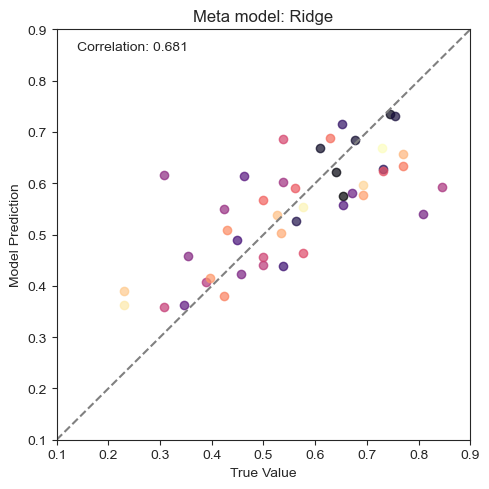

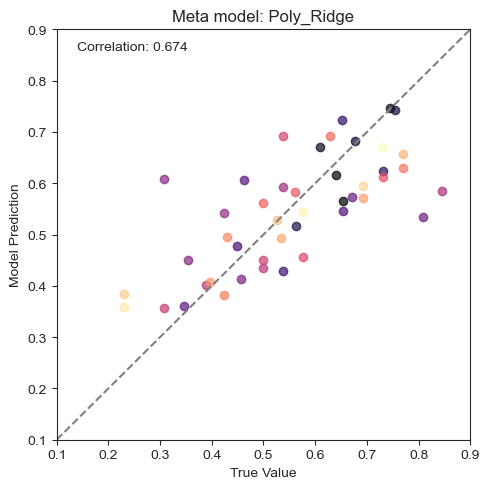

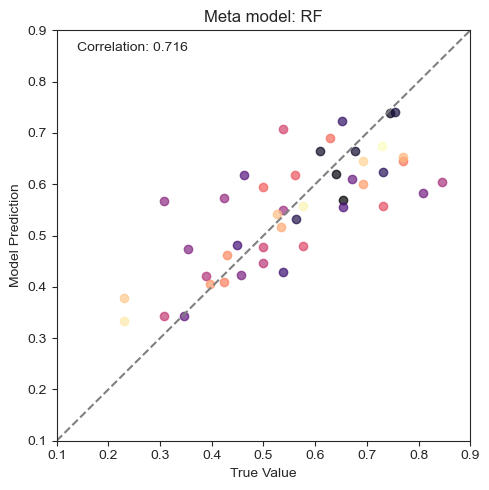

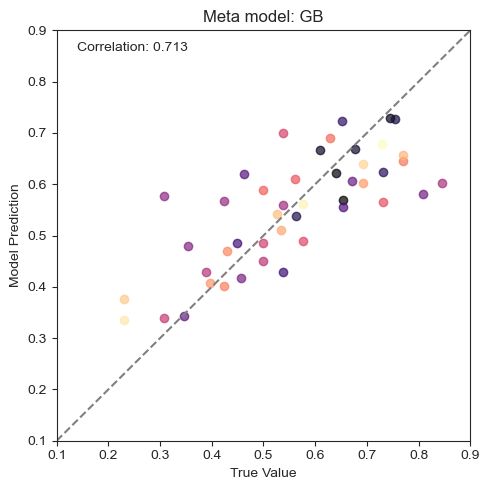

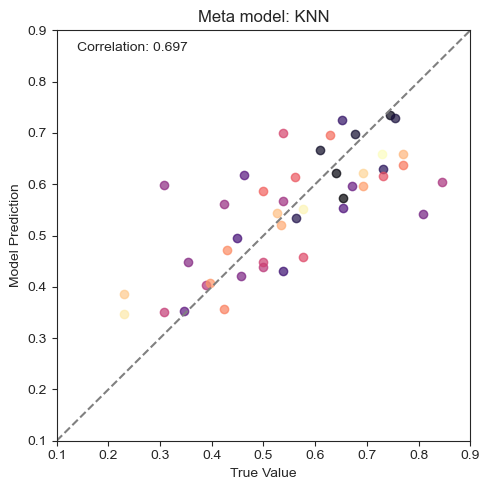

In [23]:
# Color map for all data points
num_points = len(leaderboard_predictions[list(leaderboard_predictions.keys())[0]])
colors = plt.cm.magma(np.linspace(0, 1, num_points))

for meta_model in leaderboard_predictions.keys():
    plt.figure(figsize=(5, 5))
    
    # Use the same color for each point across all plots
    for i in range(num_points):
        y_true = (y_true_leaderboard[0::2] +  y_true_leaderboard[1::2])/2
        plt.scatter(y_true[i], 
                    leaderboard_predictions[meta_model][i], 
                    color=colors[i], 
                    alpha=0.7)

    plt.xlim(.1, .9)
    plt.ylim(.1, .9)
    plt.xlabel('True Value')
    plt.ylabel('Model Prediction')
    plt.title(f'Meta model: {meta_model}')
    
    # Add y=x line
    plt.plot([.1, .9], [.1, .9], color='grey', linestyle='--')

    # Calculate and add correlation
    correlation, _ = stats.pearsonr(y_true, leaderboard_predictions[meta_model])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

----

### 4. Save test prediction

In [24]:
test_predictions = predict_stacked_ensemble(X_dense_test, X_sparse_test, final_models)
test_predictions_aug = predict_stacked_ensemble(X_dense_test, X_sparse_test, final_models_aug)

#### Saving test results:

In [25]:
def create_submission_files(meta_model, out_folder):
    # Read to be filled out form
    leaderboards_submission_form = pd.read_csv('./Test/Submission/Leaderboard_set_Submission_form.csv', index_col = 0)
    test_submission_form = pd.read_csv('./Test/Submission/Test_set_Submission_form.csv', index_col = 0)
    print(f'Test_submission_form created for {meta_model}')
    
    # Write prediction column
    # Use model trained on training
    leaderboards_submission_form['Predicted_Experimental_Values'] = leaderboard_predictions[meta_model] 
    # Use model trained on training + Leaderboard
    test_submission_form['Predicted_Experimental_Values'] = test_predictions_aug[meta_model] 
    print(f'Leaderboard_submission_form created for {meta_model}')

    leaderboards_submission_form.to_csv(f'./Test/Submission/{out_folder}/Leaderboard_set_Submission_form_{meta_model}.csv')
    test_submission_form.to_csv(f'./Test/Submission/{out_folder}/Test_set_Submission_form_{meta_model}.csv')

In [26]:
meta_model = 'RF'
out_folder = 'Meta_symmetric_final'

In [27]:
create_submission_files(meta_model, out_folder)

Test_submission_form created for RF
Leaderboard_submission_form created for RF
